In [826]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from math import ceil
from scipy.stats import norm
warnings.filterwarnings('ignore')

In [645]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

In [646]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
test_res = pd.read_csv('./data/sample_submission.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [647]:
df_test = df_test.merge(test_res, on='Id', how='inner')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,169277.052498
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,187758.393989
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,183583.683570
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,179317.477511
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,150730.079977


In [648]:
df = df.drop(columns=['Id'])
df_test = df_test.drop(columns=['Id'])

## Посмотрим на распределение целевой метки т.е. стоимости квартиры

In [831]:
print("Коэф. ассиметрии: %f" % df_train['SalePrice'].skew())
print("Коэф. эксцесса: %f" % df_train['SalePrice'].kurt())

Коэф. ассиметрии: 1.882876
Коэф. эксцесса: 6.536282


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

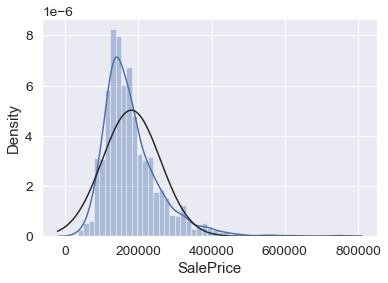

In [827]:
sns.distplot(df['SalePrice'],fit=norm)

Выше на графике, приведены две прямые: синяя -- распределения нашего целевой метки, темно-синее -- нормальное распределение. Можно увидеть что они достаточно похожи, однако наш распределение все-таки не нормальное.Выше также были показаны коэф ассиметрии( мера скошенности вправо влево относительно моды) и эксцесс (мера вытянутости) и как видно они не равны нулю, что свидетельствует о ненормальности распределения.

In [650]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [651]:
all_data = pd.concat((df, df_test))
all_data_na = ((all_data.isnull().sum() / len(all_data)) * 100) 
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

Text(0.5, 1.0, 'Процент пустых значений для каждого признака ')

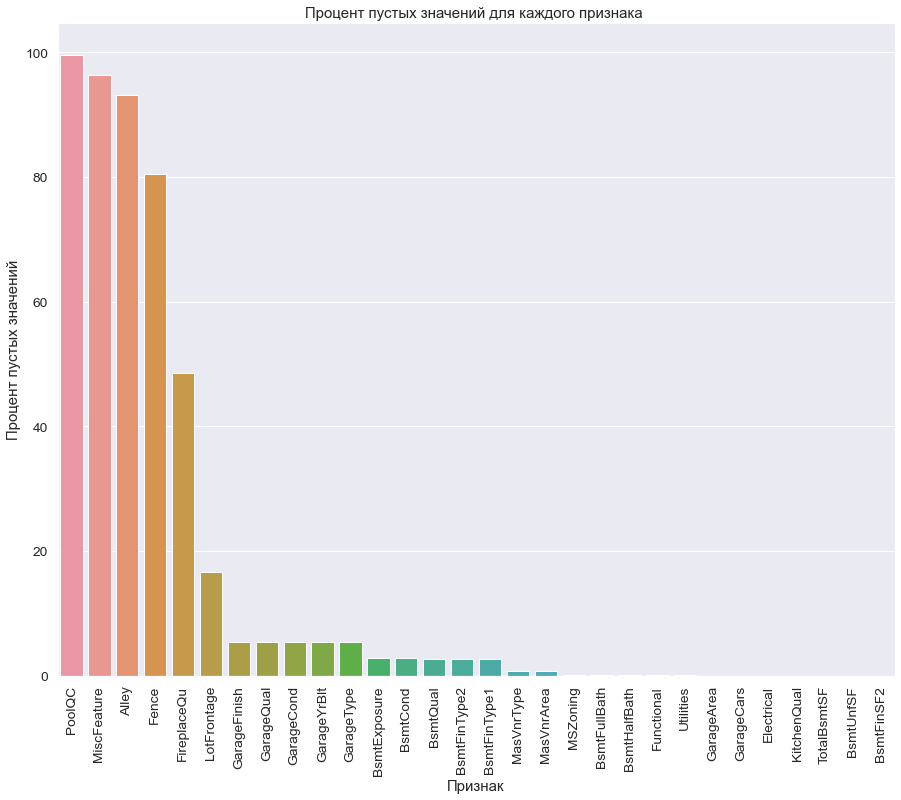

In [652]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Признак', fontsize=15)
plt.ylabel('Процент пустых значений', fontsize=15)
plt.title('Процент пустых значений для каждого признака ', fontsize=15)

## Выше можно увидеть что для некоторых признаков большая часть значений является Nan. Их следует удалить, так как восполнение значений вряд ли приведет к улучшению качества модели в связи малым кол-вом примеров 

In [653]:
df = df.drop(columns=['MiscFeature','Alley','PoolQC','Fence','FireplaceQu'])
df_test = df_test.drop(columns=['MiscFeature','Alley','PoolQC','Fence','FireplaceQu'])

In [654]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [655]:
str_columns = df.loc[:, df.dtypes == 'object'].columns
percentage = {}
for column in str_columns:
    percentage[column] = 100*df[column].value_counts()[df[column].mode().values].sum()/len(df[column])
col = []
values = []
for k in sorted(percentage, key=percentage.get, reverse=True):
    col.append(k)
    values.append(percentage[k])

Text(0.5, 1.0, 'Частота  встречаемости наиболее распр значения по каждому признаку')

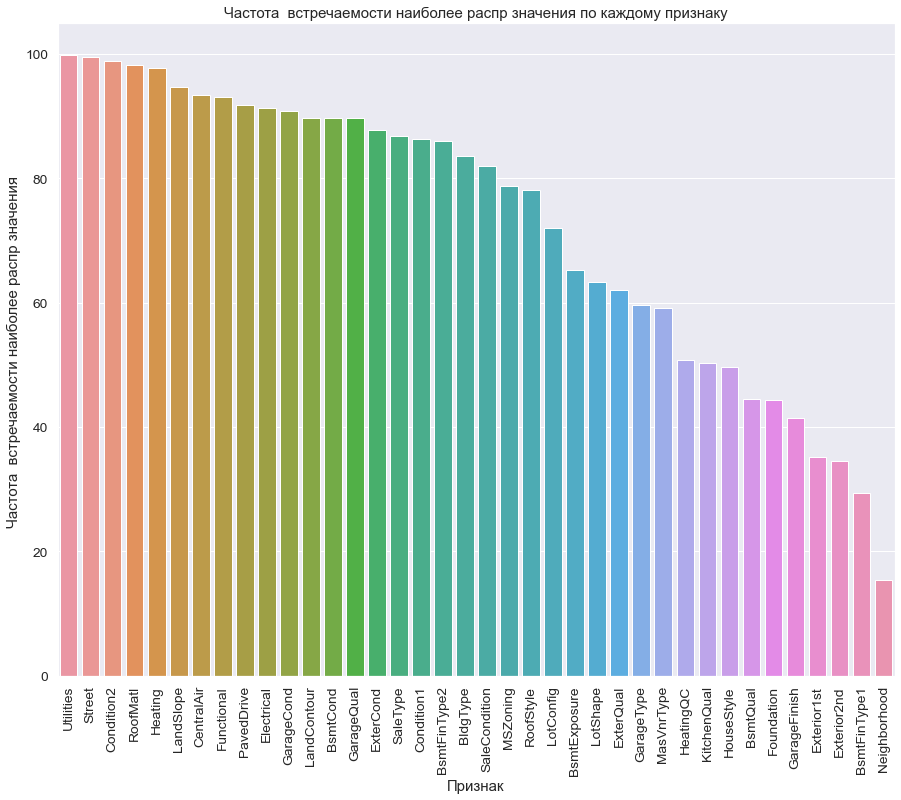

In [656]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=col, y= values)
plt.xlabel('Признак', fontsize=15)
plt.ylabel('Частота  встречаемости наиболее распр значения ', fontsize=15)
plt.title('Частота  встречаемости наиболее распр значения по каждому признаку', fontsize=15)

## Посмотрев на кол-во значений для категориальных признаков, можно заметить, что некоторые из них имеют практически для всех наблюдений одинаковые значения. Следовательно эти признаки так же можно удалить, так как они их влияние на результат будет минимальным

In [657]:
df = df.drop(columns=['Functional','GarageCond','GarageQual','KitchenQual','CentralAir','Electrical','Heating',
                      'RoofMatl','Condition2','LotConfig','Utilities','LandContour','Street'])
df_test = df_test.drop(columns=['Functional','GarageCond','GarageQual','KitchenQual','CentralAir','Electrical','Heating',
                      'RoofMatl','Condition2','LotConfig','Utilities','LandContour','Street'])

In [658]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Gtl,CollgCr,Norm,1Fam,2Story,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Reg,Gtl,Veenker,Feedr,1Fam,1Story,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,IR1,Gtl,CollgCr,Norm,1Fam,2Story,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,IR1,Gtl,Crawfor,Norm,1Fam,2Story,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,IR1,Gtl,NoRidge,Norm,1Fam,2Story,...,0,0,0,0,0,12,2008,WD,Normal,250000


<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

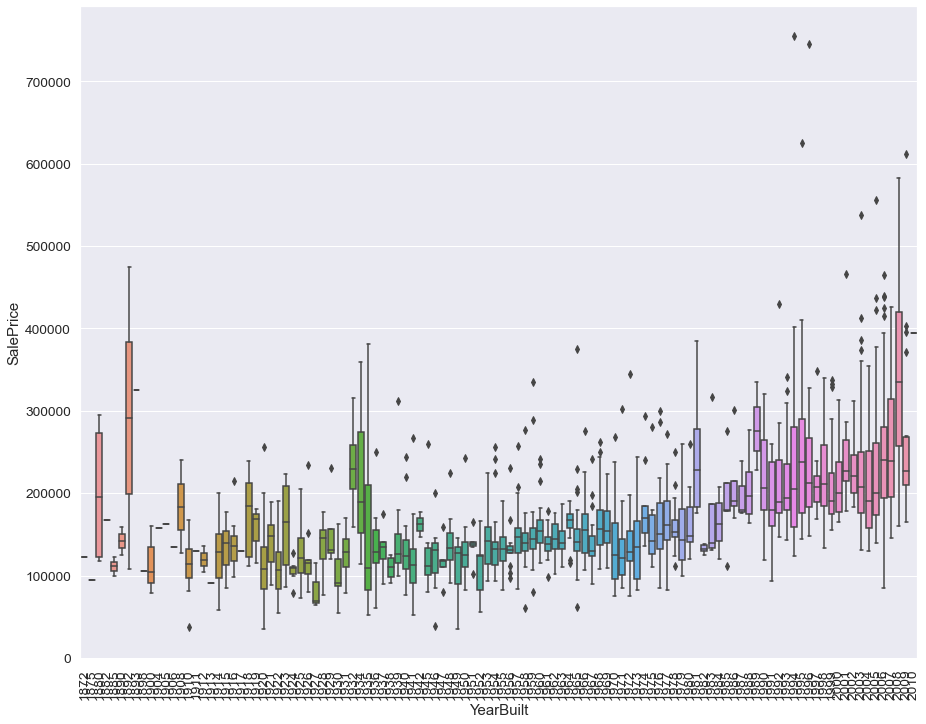

In [659]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.boxplot(x='YearBuilt', y='SalePrice', data=df)

На данном графике изображеная зависимость между ценой на дом и года его постройки. По графику можно сделать вывод: новые дома(от 1990 до н.в) и старые дома (19 века) стоит в больше, чем дома 50 годов прошлого века. Это скорее всего обусловлено тем что новые дома самые технологичные и комфортные, а старые дома из-за своей рарететности

<AxesSubplot:>

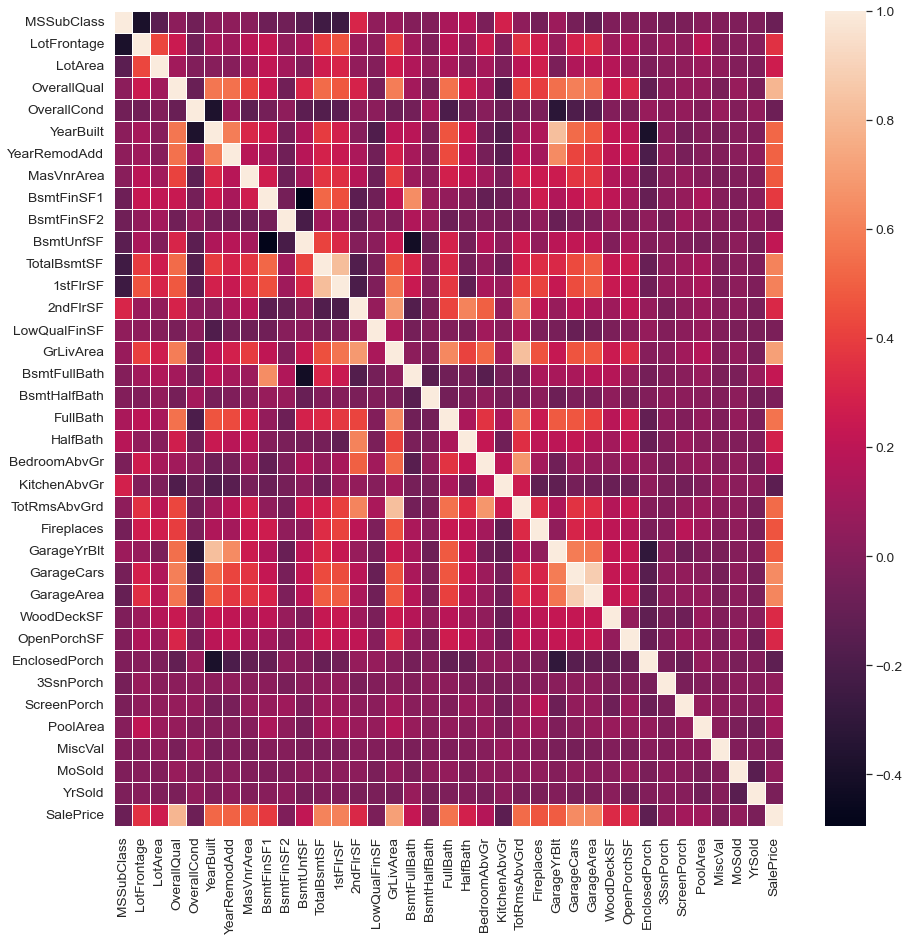

In [660]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),linewidths=.5,ax=ax)

## Посмотрим 10 признаков, у которых наибольшая корреляция с нашей целевой меткой

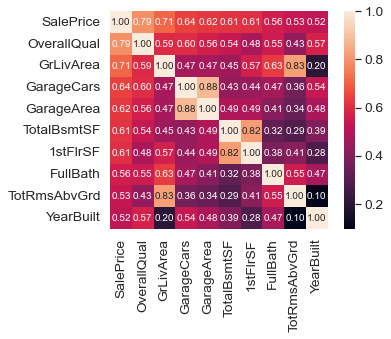

In [661]:
k = 10 
cols = df.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Построим точечную диграмму для каждого признака и цены дома из вышепостроенной тепловой карты

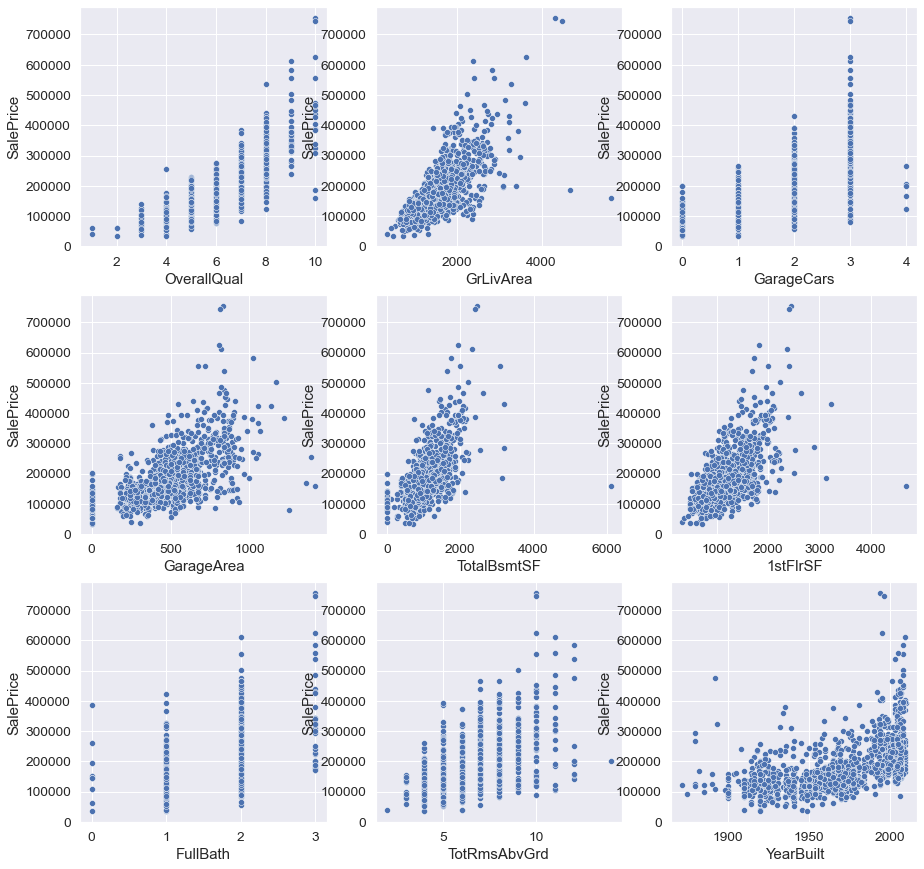

In [662]:
fig, axs = plt.subplots(3,3,figsize=(15,15))
cols = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt']
row = 0
column = 0
for col in cols:
    sns.scatterplot(data=df, x=col, y='SalePrice',ax=axs[row,column])
    column += 1
    if column >= 3:
        column = 0 
        row+= 1
    

Данные диаграммы рассеивания показывают, как наши признаки влиюят на цену дому. Например признак чем больше значение GrLivArea тем дороже дом. Или можно увидеть, что если у дома нету гаража или он 1, то дом намного дешевле чем дом с 2 или более гаражами. 

## Следующим шагом будет заполнение пустых яйчеек, для этого пустые значения будем заполнять наиболее встречающ. значением в данном столбце

In [663]:
imp_mean = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imp_mean.fit_transform(df),columns=df.columns).astype(df.dtypes.to_dict())
df_test = pd.DataFrame(imp_mean.fit_transform(df_test),columns=df_test.columns).astype(df_test.dtypes.to_dict())

In [664]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Gtl,CollgCr,Norm,1Fam,2Story,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Reg,Gtl,Veenker,Feedr,1Fam,1Story,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,IR1,Gtl,CollgCr,Norm,1Fam,2Story,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,IR1,Gtl,Crawfor,Norm,1Fam,2Story,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,IR1,Gtl,NoRidge,Norm,1Fam,2Story,...,0,0,0,0,0,12,2008,WD,Normal,250000


## Так как у нас задача регрессии, то следует перевести наши категориальные признаки в количественные. Для этого была использована библиотека category_encoders и ее метод TargetEncoder. Я решил использовать данный метод, так как он сохраняет смысл переменных, т.е. влияние данного признака на целевую метку и при этом  не увеличивает кол-во столбцов

In [665]:
for column in df.columns[:-1]:
    if df[column].dtype == 'object':
        encoder = TargetEncoder()
        df[column] = encoder.fit_transform(df[column], df.iloc[:,-1:])

In [666]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,191004.994787,65.0,8450,164754.818378,179956.799566,197965.773333,184495.492063,185763.807377,210051.764045,...,0,0,0,0,0,2,2008,173401.836622,175202.219533,208500
1,20,191004.994787,80.0,9600,164754.818378,179956.799566,238770.100937,142475.481481,185763.807377,175985.477961,...,0,0,0,0,0,5,2007,173401.836622,175202.219533,181500
2,60,191004.994787,68.0,11250,206101.665289,179956.799566,197965.773333,184495.492063,185763.807377,210051.764045,...,0,0,0,0,0,9,2008,173401.836622,175202.219533,223500
3,70,191004.994787,60.0,9550,206101.665289,179956.799566,210624.725490,184495.492063,185763.807377,210051.764045,...,272,0,0,0,0,2,2006,173401.836622,146526.623762,140000
4,60,191004.994787,84.0,14260,206101.665289,179956.799566,335295.317073,184495.492063,185763.807377,210051.764045,...,0,0,0,0,0,12,2008,173401.836622,175202.219533,250000


In [667]:
for column in df_test.columns[:-1]:
    if df_test[column].dtype == 'object':
        encoder = TargetEncoder()
        df_test[column] = encoder.fit_transform(df_test[column], df_test.iloc[:,-1:])

In [668]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,171330.497713,80.0,11622,177135.491809,179358.299771,180234.977770,181305.176091,181251.505943,176483.575476,...,0,0,120,0,0,6,2010,179118.867479,178550.302522,169277.052498
1,20,182020.555928,81.0,14267,182314.892527,179358.299771,180234.977770,178596.759124,181251.505943,176483.575476,...,0,0,0,0,12500,6,2010,179118.867479,178550.302522,187758.393989
2,60,182020.555928,74.0,13830,182314.892527,179358.299771,185457.440364,178596.759124,181251.505943,183986.171646,...,0,0,0,0,0,3,2010,179118.867479,178550.302522,183583.683570
3,60,182020.555928,78.0,9978,182314.892527,179358.299771,185457.440364,178596.759124,181251.505943,183986.171646,...,0,0,0,0,0,6,2010,179118.867479,178550.302522,179317.477511
4,120,182020.555928,43.0,5005,182314.892527,179358.299771,182297.476307,178596.759124,158097.497383,176483.575476,...,0,0,144,0,0,1,2010,179118.867479,178550.302522,150730.079977


## Для решения данной задачи регрессии будет использовано три модели: линейная регрессия Лассо, случайный лес и градиентный бустинг

In [669]:
X,y = df.iloc[:,0:-1],df['SalePrice']
X_test,y_test = df_test.iloc[:,0:-1],df_test['SalePrice']

In [670]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)

In [671]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [535]:
clf_linear = make_pipeline(RobustScaler(), 
                    GridSearchCV(Lasso(random_state=1),
                                 param_grid={'alpha':[0.1,0.2,0.5,0.8,1,1.2,1.5],'max_iter':[1000,1300,1500,1700]}
                                ))

In [537]:
clf_linear.fit(X_train,y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=Lasso(random_state=1),
                              param_grid={'alpha': [0.1, 0.2, 0.5, 0.8, 1, 1.2,
                                                    1.5],
                                          'max_iter': [1000, 1300, 1500,
                                                       1700]}))])

In [538]:
y_pred_valid_linear = clf_linear.predict(X_valid)

In [539]:
r2_score(y_pred_valid_linear,y_valid)

0.8180520859339865

In [540]:
y_pred_linear = clf_linear.predict(X_test)

In [541]:
r2_score(y_pred_linear,y_test)

0.18697802779443595

Посмотрим как справится с задачей случайный лес

In [559]:
params = {
    'max_depth':[5,7,9,11,13,15,20,30],
    'n_estimators':[100,200,300,500,1000],
    'min_samples_split':[2,4,6,10,18]
}

In [560]:
clf = make_pipeline(GridSearchCV(RandomForestRegressor(random_state=1,n_jobs=-1),
                    param_grid=params
                    ))

In [561]:
clf.fit(X_train,y_train)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1,
                                                              random_state=1),
                              param_grid={'max_depth': [5, 7, 9, 11, 13, 15, 20,
                                                        30],
                                          'min_samples_split': [2, 4, 6, 10,
                                                                18],
                                          'n_estimators': [100, 200, 300, 500,
                                                           1000]}))])

In [562]:
y_pred_valid = clf.predict(X_valid)

In [563]:
r2_score(y_pred_valid,y_valid)

0.8671522396216194

In [564]:
y_pred = clf.predict(X_test)

In [565]:
r2_score(y_pred,y_test)

0.12469227316783515

In [567]:
boost = xgb.XGBRegressor(n_estimators=1500,max_depth=15,learning_rate=0.1,random_state =1, n_jobs= -1,gamma=0.0468)

In [569]:
boost.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0468, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [570]:
y_pred_valid_boost = boost.predict(X_valid)

In [571]:
r2_score(y_pred_valid_boost,y_valid)

0.8610004505407175

In [572]:
y_pred_boost = clf.predict(X_test)

In [573]:
r2_score(y_pred_boost,y_test)

0.12469227316783515

Как мы видим ни один из 3 методов не мог хорошо решить задачу. Можно заметить, что оценка работы на валидационных данных и тестовых данных сильно разнится. Это скорее связано с тем, что наши обучающие и тестовые данные из разных источников и моделям банально сложно предсказывать цену на совершенно других данных

## Среди 3 методов, наилучшим оказался линейная регрессия Лассо. Посмотрим какие признаки оказывали наибольшее влияние при расчете цен

In [823]:
def visualize_coefficients(classifier, feature_names, n_top_features=15):
    coef  = classifier.coef_.ravel()
    positive = np.argsort(coef)[-n_top_features:]
    negative = np.argsort(coef)[:n_top_features]
    all_features = np.hstack([negative, positive])
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[all_features]]
    plt.bar(np.arange(2 * n_top_features), coef[all_features], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[all_features], rotation=60, ha="right");
    plt.title('15 признаков, которые в наибольшей степени влияли на результат прогноза модели')

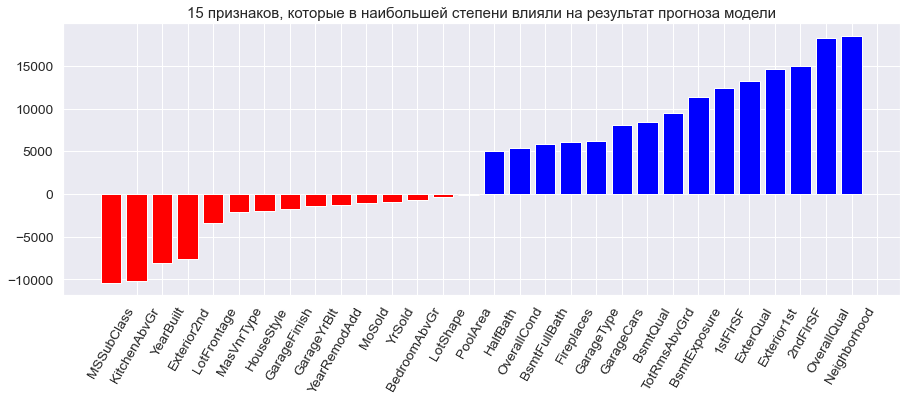

In [824]:
classifier = clf_linear[1].best_estimator_
visualize_coefficients(classifier,df.columns)

На удорожание квартиры в первую очередь влияли такие признаки, как  Neighborthood и OverallQual. Первый признак это расположение в городе, а второй показывает насколько качественно выполнен дом. Негативно на цену жилья в свою очередь влияет тип жилья т.е. MSSubClass и где именно расположена кухня

## Проверка даннных на наличие ковариантного сдвига

In [672]:
df['is_train'] = 1
df_test['is_train'] = 0

In [680]:
df_combine = pd.concat([df, df_test], axis=0, ignore_index=True)
df_combine = df_combine.drop('SalePrice', axis =1)

y_combine = df_combine['is_train'].values
x_combine = df_combine.drop('is_train', axis=1).values 

tst, trn = df_test.values, X_train.values

In [681]:
rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y_combine.shape)

In [682]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x_combine, y_combine)):
    X_train_comb, X_test_comb = x_combine[train_idx], x_combine[test_idx]
    y_train_comb, y_test_comb = y_combine[train_idx], y_combine[test_idx]
 
    rfc.fit(X_train_comb, y_train_comb)
    probs = rfc.predict_proba(X_test_comb)[:, 1]
    predictions[test_idx] = probs

In [683]:
from sklearn.metrics import roc_auc_score
print('ROC-AUC:', roc_auc_score(y_true=y_combine, y_score=predictions))

ROC-AUC: 1.0


## Показатель ROC-AUC равен 1, что означает о наличии ковариативного сдвига

Попытаемся решить данную проблему добавив веса, чтобы увеличить вес тех наблюдений, которые выглядят схожими с тестовой выборкой

In [684]:
predictions_train = predictions[:len(trn)] 
weights = (1./predictions_train) - 1. 
weights /= np.mean(weights)

In [753]:
lasso = make_pipeline(RobustScaler(), 
                    GridSearchCV(Lasso(random_state=1),
                                 param_grid={'alpha':[0.1,0.2,0.5,0.8,1,1.2,1.5],'max_iter':[1000,1300,1500,1700]}
                                ))

In [756]:
lasso.fit(X_train,y_train,**{'gridsearchcv__sample_weight':weights})

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=Lasso(random_state=1),
                              param_grid={'alpha': [0.1, 0.2, 0.5, 0.8, 1, 1.2,
                                                    1.5],
                                          'max_iter': [1000, 1300, 1500,
                                                       1700]}))])

In [757]:
y_pred_valid_linear = lasso.predict(X_valid)

In [758]:
r2_score(y_pred_valid_linear,y_valid)

0.7327703093520073

In [759]:
y_pred_linear = lasso.predict(X_test)

In [760]:
r2_score(y_pred_linear,y_test)

0.08924202925614722